In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gpflow
import time
from gpflow.utilities import print_summary
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [2]:
def cwc(Y, predX_mean, predX_var, scaler, mu = 0.5, eta = 50):
    testY = scaler.inverse_transform(Y)
    UB = scaler.inverse_transform(predX_mean + 1.96*np.sqrt(predX_var))
    LB = scaler.inverse_transform(predX_mean - 1.96*np.sqrt(predX_var))
    RMSE = np.sqrt(mse(testY,scaler.inverse_transform(predX_mean)))
    CV = RMSE/np.mean(testY)
    coverage = (testY < UB) & (testY > LB)
    picp = np.sum(coverage) / len(testY)
    mpiw = np.sum(UB-LB) / len(testY)
    nmpiw = mpiw / (testY.max() - testY.min())
    gamma = 0 if picp >= mu else 1
    cwc = nmpiw + gamma*np.exp(-eta * (picp-mu))
    return cwc, picp, nmpiw, RMSE, CV

In [3]:
data = pd.read_csv('combined_dt.csv',index_col=0,parse_dates=True)
d = pd.read_csv('bind_lst_till0821_2.csv')
# d['Temp_median'] = data.groupby(by='date')['P53 OutdoorTempAve'].median().to_numpy()
d['Temp_std'] = data.groupby(by='date')['P53 OutdoorTempAve'].std().to_numpy()

d = d.iloc[:-3] # end of experiment
d = d[~(d['label_date'].isin(['May 23','Jul 18','Jul 23','Aug 01','Aug 02','Aug 06','Aug 07','Aug 12','Aug 16']))] # incomplete data

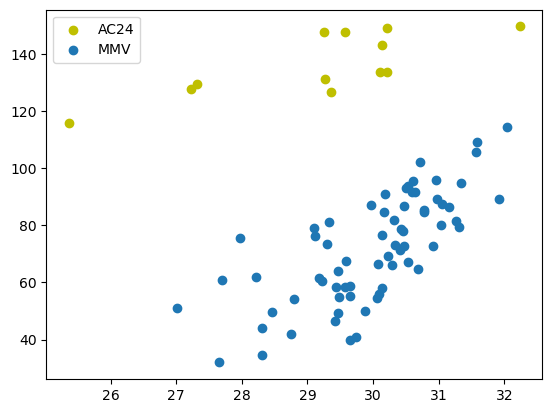

In [4]:
base = d[d['is_MMV']=='No']
mmv = d[d['is_MMV']=='Yes']
plt.scatter(base['P53 OutdoorTempAve'],base['ClgRelatedPower_kWh'],c='y',label='AC24')
plt.scatter(mmv['P53 OutdoorTempAve'],mmv['ClgRelatedPower_kWh'],label='MMV')
plt.legend()

## best model so far regarding leave-one-out cross validation
best model without Aug data
- feature: average outdoor temperature, total rain hours, variance of outdoor temperature, average relative humidity
- kernel: Matern 3/2

best model after finalizing the data
- feature: average outdoor temperature, variance of outdoor temperature, average relative humidity
- kernel: Matern 1/2

In [58]:
inputs = ['P53 OutdoorTempAve','Temp_std','daily_ave_RH']
X = np.asarray(mmv[inputs])
scalerX = StandardScaler()
scalerX.fit(X)
X = scalerX.transform(X)
output = 'ClgRelatedPower_kWh'
Y = np.asarray(mmv[output]).reshape(-1,1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

X_mean = []
X_var = []

for i in range(len(mmv)):

    Xs = np.concatenate([X[:i],X[i+1:]])
    Ys = np.concatenate([Y[:i],Y[i+1:]])
    
    # k1 = gpflow.kernels.Matern12(active_dims=[0])
    # k2 = gpflow.kernels.SquaredExponential(active_dims=[1])
    # k3 = gpflow.kernels.SquaredExponential(active_dims=[2])
    # k = k1 * k2 * k3
    # k = gpflow.kernels.Matern12(lengthscales=[1,.1,0.5,.5])
    k = gpflow.kernels.Matern12()
    m1= gpflow.models.GPR(data=(Xs, Ys), kernel=k)
    # print_summary(m1)
    
    opt = gpflow.optimizers.Scipy()
    t = time.time()
    opt_logs = opt.minimize(m1.training_loss, m1.trainable_variables, options=dict(maxiter=100))

    predX_mean, predX_var = m1.predict_f(X[i].reshape(1,-1))
    X_mean.append(predX_mean[0])
    X_var.append(predX_var[0])

print('test',cwc(Y, X_mean, X_var, scalerY))

test (0.451709750238716, 0.8970588235294118, 0.451709750238716, 10.562788490842513, 0.14692716689964846)


#### visualization of daily prediction results

0.6785442264684567

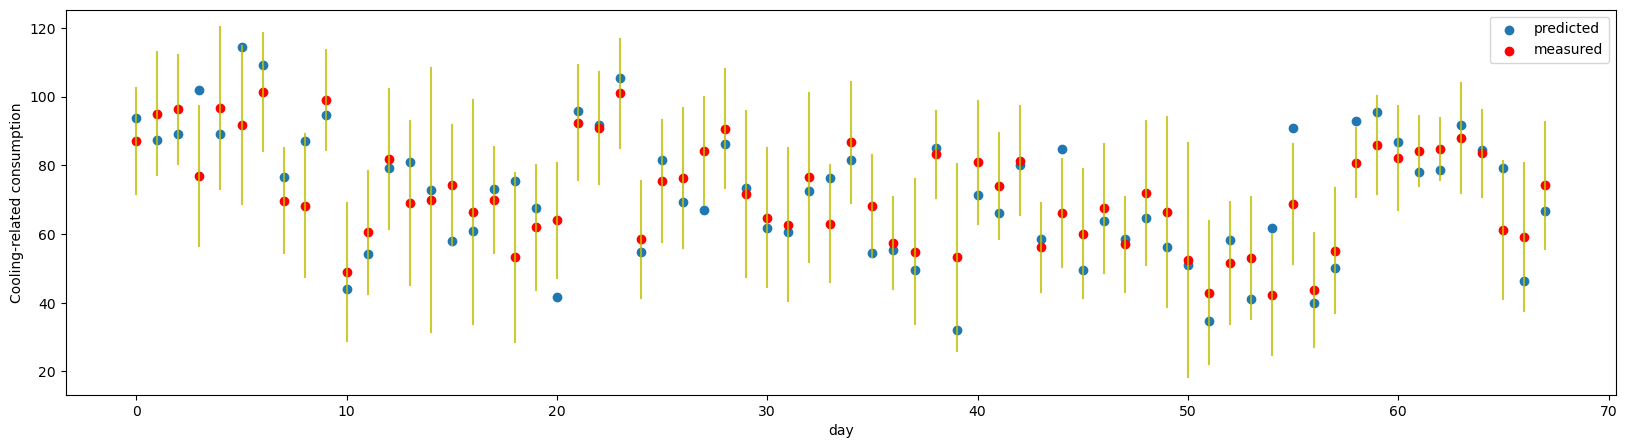

In [25]:
UB = scalerY.inverse_transform(X_mean + 1.96*np.sqrt(X_var))
LB = scalerY.inverse_transform(X_mean - 1.96*np.sqrt(X_var))

fig,ax = plt.subplots(figsize=(20,5))
plt.scatter(np.arange(len(Y)),scalerY.inverse_transform(Y),label='predicted')
for i in range(len(Y)):
    plt.plot([i,i],[UB[i],LB[i]],c='y',alpha=.8)
plt.scatter(np.arange(len(Y)),scalerY.inverse_transform(X_mean),c='r',label='measured')
plt.xlabel('day')
plt.ylabel('Cooling-related consumption')
plt.legend()
r2_score(Y, X_mean)

## energy saving estimation using historical data

#### best MMV model applied on early days with AC24

In [64]:
inputs = ['P53 OutdoorTempAve','Temp_std','daily_ave_RH']
X = np.asarray(mmv[inputs])#[train,:]
scalerX = StandardScaler()
scalerX.fit(X)
X = scalerX.transform(X)
output = 'ClgRelatedPower_kWh'
Y = np.asarray(mmv[output]).reshape(-1,1)#[train,:]
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

k = gpflow.kernels.Matern12()
m1= gpflow.models.GPR(data=(X, Y), kernel=k)
# print_summary(m1)

opt = gpflow.optimizers.Scipy()
t = time.time()
opt_logs = opt.minimize(m1.training_loss, m1.trainable_variables, options=dict(maxiter=100))

In [65]:
testX = scalerX.transform(np.asarray(base[inputs]))
predX_mean, predX_var = m1.predict_f(testX)

base['pred_MMV'] = scalerY.inverse_transform(predX_mean).reshape(1,-1)[0]

/var/folders/j0/jwr38xvn0nzgzgmrpr3fxyxc0000gn/T/ipykernel_98634/3668274483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['pred_MMV'] = scalerY.inverse_transform(predX_mean).reshape(1,-1)[0]


pred_MMV                821.614394
ClgRelatedPower_kWh    1635.220000
dtype: float64

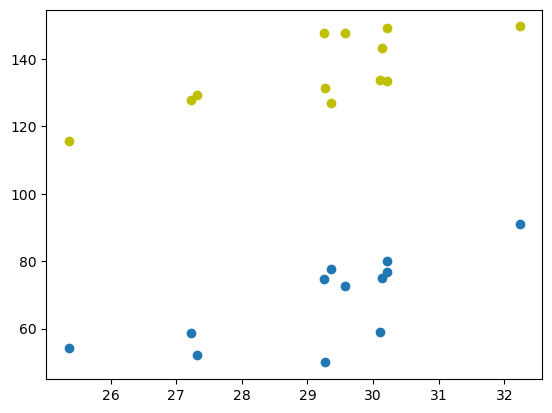

In [66]:
plt.scatter(base['P53 OutdoorTempAve'],base['pred_MMV'])
plt.scatter(base['P53 OutdoorTempAve'],base['ClgRelatedPower_kWh'],c='y')
base[['pred_MMV','ClgRelatedPower_kWh']].sum()

In [67]:
# print('predicted MMV energy consumption sum up to %f of the AC24 consumption'%(576.763327/1233.000000))
print('predicted MMV energy consumption sum up to %f of the AC24 consumption'%(821.614394/1635.220000))

predicted MMV energy consumption sum up to 0.502449 of the AC24 consumption


##### adding the "total_rain_hours" as input yielded 3% more energy saving but 0.4% higher CVRMSE

#### AC24 model applied on days with MMV, using same features for consistency¶

In [81]:
inputs = ['P53 OutdoorTempAve','Temp_std','daily_ave_RH']
# inputs = ['Tout','solar','workday','workhour']
X = np.asarray(base[inputs])#[train,:]
scalerX = StandardScaler()
scalerX.fit(X)
X = scalerX.transform(X)
output = 'ClgRelatedPower_kWh'
Y = np.asarray(base[output]).reshape(-1,1)#[train,:]
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

k = gpflow.kernels.Linear()
m_base= gpflow.models.GPR(data=(X, Y), kernel=k)
# print_summary(m1)

opt = gpflow.optimizers.Scipy()
t = time.time()
opt_logs = opt.minimize(m_base.training_loss, m_base.trainable_variables, options=dict(maxiter=100))

In [82]:
testX = scalerX.transform(np.asarray(mmv[inputs]))
predX_mean, predX_var = m_base.predict_f(testX)
mmv['pred_AC'] = scalerY.inverse_transform(predX_mean).reshape(1,-1)[0]

/var/folders/j0/jwr38xvn0nzgzgmrpr3fxyxc0000gn/T/ipykernel_98634/1991621511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmv['pred_AC'] = scalerY.inverse_transform(predX_mean).reshape(1,-1)[0]


pred_AC                9423.571368
ClgRelatedPower_kWh    4888.610000
dtype: float64

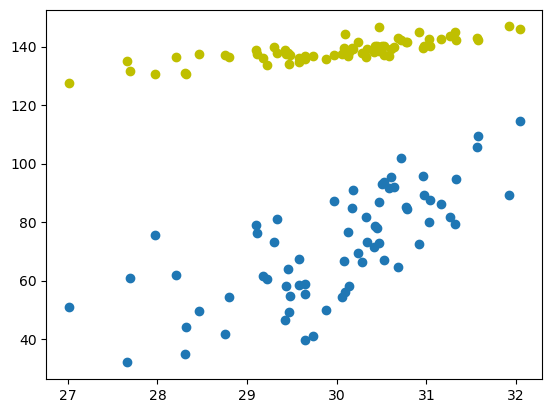

In [83]:
plt.scatter(mmv['P53 OutdoorTempAve'],mmv['pred_AC'],c='y')
plt.scatter(mmv['P53 OutdoorTempAve'],mmv['ClgRelatedPower_kWh'])
mmv[['pred_AC','ClgRelatedPower_kWh']].sum()

In [84]:
print('MMV energy consumption sum up to %f of the predicted AC24 consumption'%(4888.610000/9423.571368))

MMV energy consumption sum up to 0.518764 of the predicted AC24 consumption


## energy saving estimation using 2023 AMY

In [85]:
from pyepw.epw import EPW
epw = EPW()
epw.read('SGP_SINGAPORE-CHANGI-IAP_486980S_23.epw')

In [86]:
amy23 = []
for wd in epw.weatherdata:
    amy23.append([wd.month, wd.day, wd.dry_bulb_temperature, wd.relative_humidity])
amy23 = pd.DataFrame(amy23,columns=['month','day','P53 OutdoorTempAve','daily_ave_RH'])
amy23['date'] = amy23['month'].astype('str') + '_' + amy23['day'].astype('str')

In [87]:
amy23_daily = amy23.groupby('date')[['P53 OutdoorTempAve','daily_ave_RH']].mean()
amy23_daily['Temp_std'] = amy23.groupby('date')['P53 OutdoorTempAve'].std()

### removed total rain hour as there's no data

In [89]:
inputs = ['P53 OutdoorTempAve','Temp_std','daily_ave_RH']
X = np.asarray(mmv[inputs])
scalerX = StandardScaler()
scalerX.fit(X)
X = scalerX.transform(X)
output = 'ClgRelatedPower_kWh'
Y = np.asarray(mmv[output]).reshape(-1,1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

k = gpflow.kernels.Matern12()
m1= gpflow.models.GPR(data=(X, Y), kernel=k)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m1.training_loss, m1.trainable_variables, options=dict(maxiter=100))


X = np.asarray(base[inputs])
X = scalerX.transform(X)
Y = np.asarray(base[output]).reshape(-1,1)
scalerYbase = StandardScaler()
scalerYbase.fit(Y)
Y = scalerYbase.transform(Y)

k = gpflow.kernels.Linear()
m_base= gpflow.models.GPR(data=(X, Y), kernel=k)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_base.training_loss, m_base.trainable_variables, options=dict(maxiter=100))

In [112]:
testX = scalerX.transform(np.asarray(amy23_daily[inputs]))
pred_mmv_mean, pred_mmv_var = m1.predict_f(testX)
pred_ac_mean, pred_ac_var = m_base.predict_f(testX)
amy23_daily['pred_MMV'] = scalerY.inverse_transform(pred_mmv_mean).reshape(1,-1)[0]
amy23_daily['pred_AC'] = scalerYbase.inverse_transform(pred_ac_mean).reshape(1,-1)[0]
amy23_daily['mmv_UB'] = scalerY.inverse_transform(pred_mmv_mean + 1.96*np.sqrt(pred_mmv_var))
amy23_daily['mmv_LB'] = scalerY.inverse_transform(pred_mmv_mean - 1.96*np.sqrt(pred_mmv_var))
amy23_daily.loc[amy23_daily['mmv_LB']<0,'mmv_LB'] = 0

pred_AC     48822.103889
pred_MMV    18830.349288
mmv_LB       9855.846947
dtype: float64

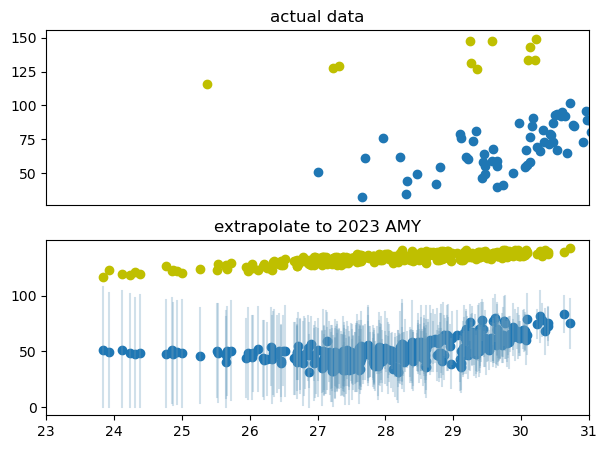

In [115]:
fig, axs = plt.subplots(2,1,figsize=(7,5))
axs[0].scatter(base['P53 OutdoorTempAve'],base['ClgRelatedPower_kWh'],c='y',label='AC24')
axs[0].scatter(mmv['P53 OutdoorTempAve'],mmv['ClgRelatedPower_kWh'],label='MMV')
axs[0].set_xlim(23,31)
axs[0].set_xticks([])
axs[0].set_title('actual data')

axs[1].scatter(amy23_daily['P53 OutdoorTempAve'],amy23_daily['pred_AC'],c='y',label='AC24')
axs[1].scatter(amy23_daily['P53 OutdoorTempAve'],amy23_daily['pred_MMV'],label='MMV')
axs[1].set_xlim(23,31)
axs[1].set_title('extrapolate to 2023 AMY')

## comment out the next 4 lines to remove confidence interval

forPlot = np.asarray(amy23_daily[['P53 OutdoorTempAve','mmv_UB','mmv_LB']])
for i in range(len(amy23_daily)):
    plt.plot([forPlot[i,0],forPlot[i,0]],[forPlot[i,1],forPlot[i,2]],c='#669bbc',alpha=.3)


amy23_daily[['pred_AC','pred_MMV','mmv_LB']].sum()

In [92]:
print('Predicted MMV energy consumption sum up to %f of the predicted AC24 consumption'%(18830.349288/48822.103889))

Predicted MMV energy consumption sum up to 0.385693 of the predicted AC24 consumption


#### this 62% saving may be a conservative estimation, using the MMV predicted lower bound gets 80% saving